### Predict the amount of nitrous oxide emitted, given values on the other sensors. 

The coursework is divided into five sections:

-  Section 1: **Exploratory data analysis and preprocessing**
-  Section 2: **Machine learning models**
-  Section 3: **Baseline performance**
-  Section 4: **Conclusion**

## Section 1: Exploratory data analysis and Data preprocessing

In [11]:
#necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerLine2D
from pprint import pprint

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style = "darkgrid")
%matplotlib inline

seed = 42

List of libraries used are mentioned in the above cell. Some of these libraries are present in either the standard library or most scientific distributions of Python. Of course, all of them can be installed with pip or conda if you are using anaconda.

Before start implementing ML models, we need to udnerstand the data. The process of understanding the data is called **Exploratory data analysis (EDA).**

In [12]:
#load the dataset
df = pd.read_csv("coursework1.csv")
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,NOX
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,81.952
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,82.377
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,83.776
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,82.505
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,82.028


The dataset has 9 features and one target variable. The shape of the dataset is (15039, 10). All the attributes are continous. 

In [13]:
#check null values
df.isnull().any()

AT      False
AP      False
AH      False
AFDP    False
GTEP    False
TIT     False
TAT     False
TEY     False
CDP     False
NOX     False
dtype: bool

There are no missing values. 

In [14]:
#summary statistics for each column
df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,NOX
count,15039.000000,15039.00000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,4.200294,25.419061,1083.798770,545.396183,134.188464,12.102353,68.190934
std,7.574323,6.41076,13.793439,0.760197,4.173916,16.527806,7.866803,15.829717,1.103196,10.470586
min,0.522300,985.85000,30.344000,2.087400,17.878000,1000.800000,512.450000,100.170000,9.904400,27.765000
25%,11.408000,1008.90000,69.750000,3.723900,23.294000,1079.600000,542.170000,127.985000,11.622000,61.303500
50%,18.186000,1012.80000,82.266000,4.186200,25.082000,1088.700000,549.890000,133.780000,12.025000,66.601000
75%,23.862500,1016.90000,90.043500,4.550900,27.184000,1096.000000,550.060000,140.895000,12.578000,73.935500
max,34.929000,1034.20000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,119.890000


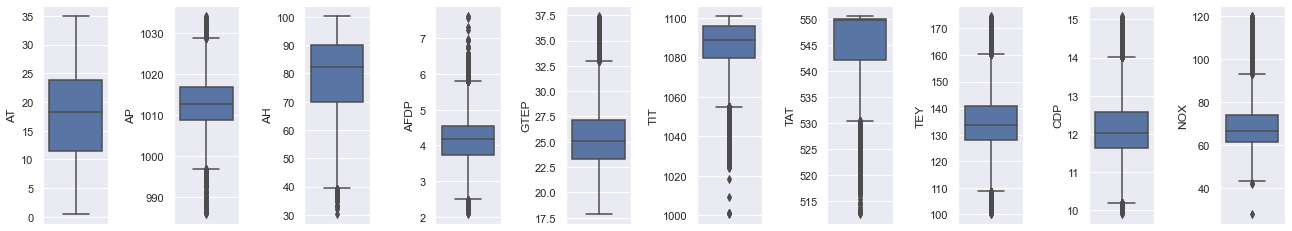

In [15]:
#boxplots of each column
fig, ax = plt.subplots(ncols = len(df.columns))
plt.subplots_adjust(right = 3, wspace = 1)

for number, column in enumerate(df.columns):
    sns.boxplot(y = df[column], ax = ax[number])

These boxplots identity some extreme values, these values are necessarily considered as outliers. The values are outside a distribution. In our case, outliers might not be due to result of mistakes.

Pair plot is a great way to see the relaton between two variables. In our case, we have only 9 features. So, it is pretty simple to analyze the relevant columns.

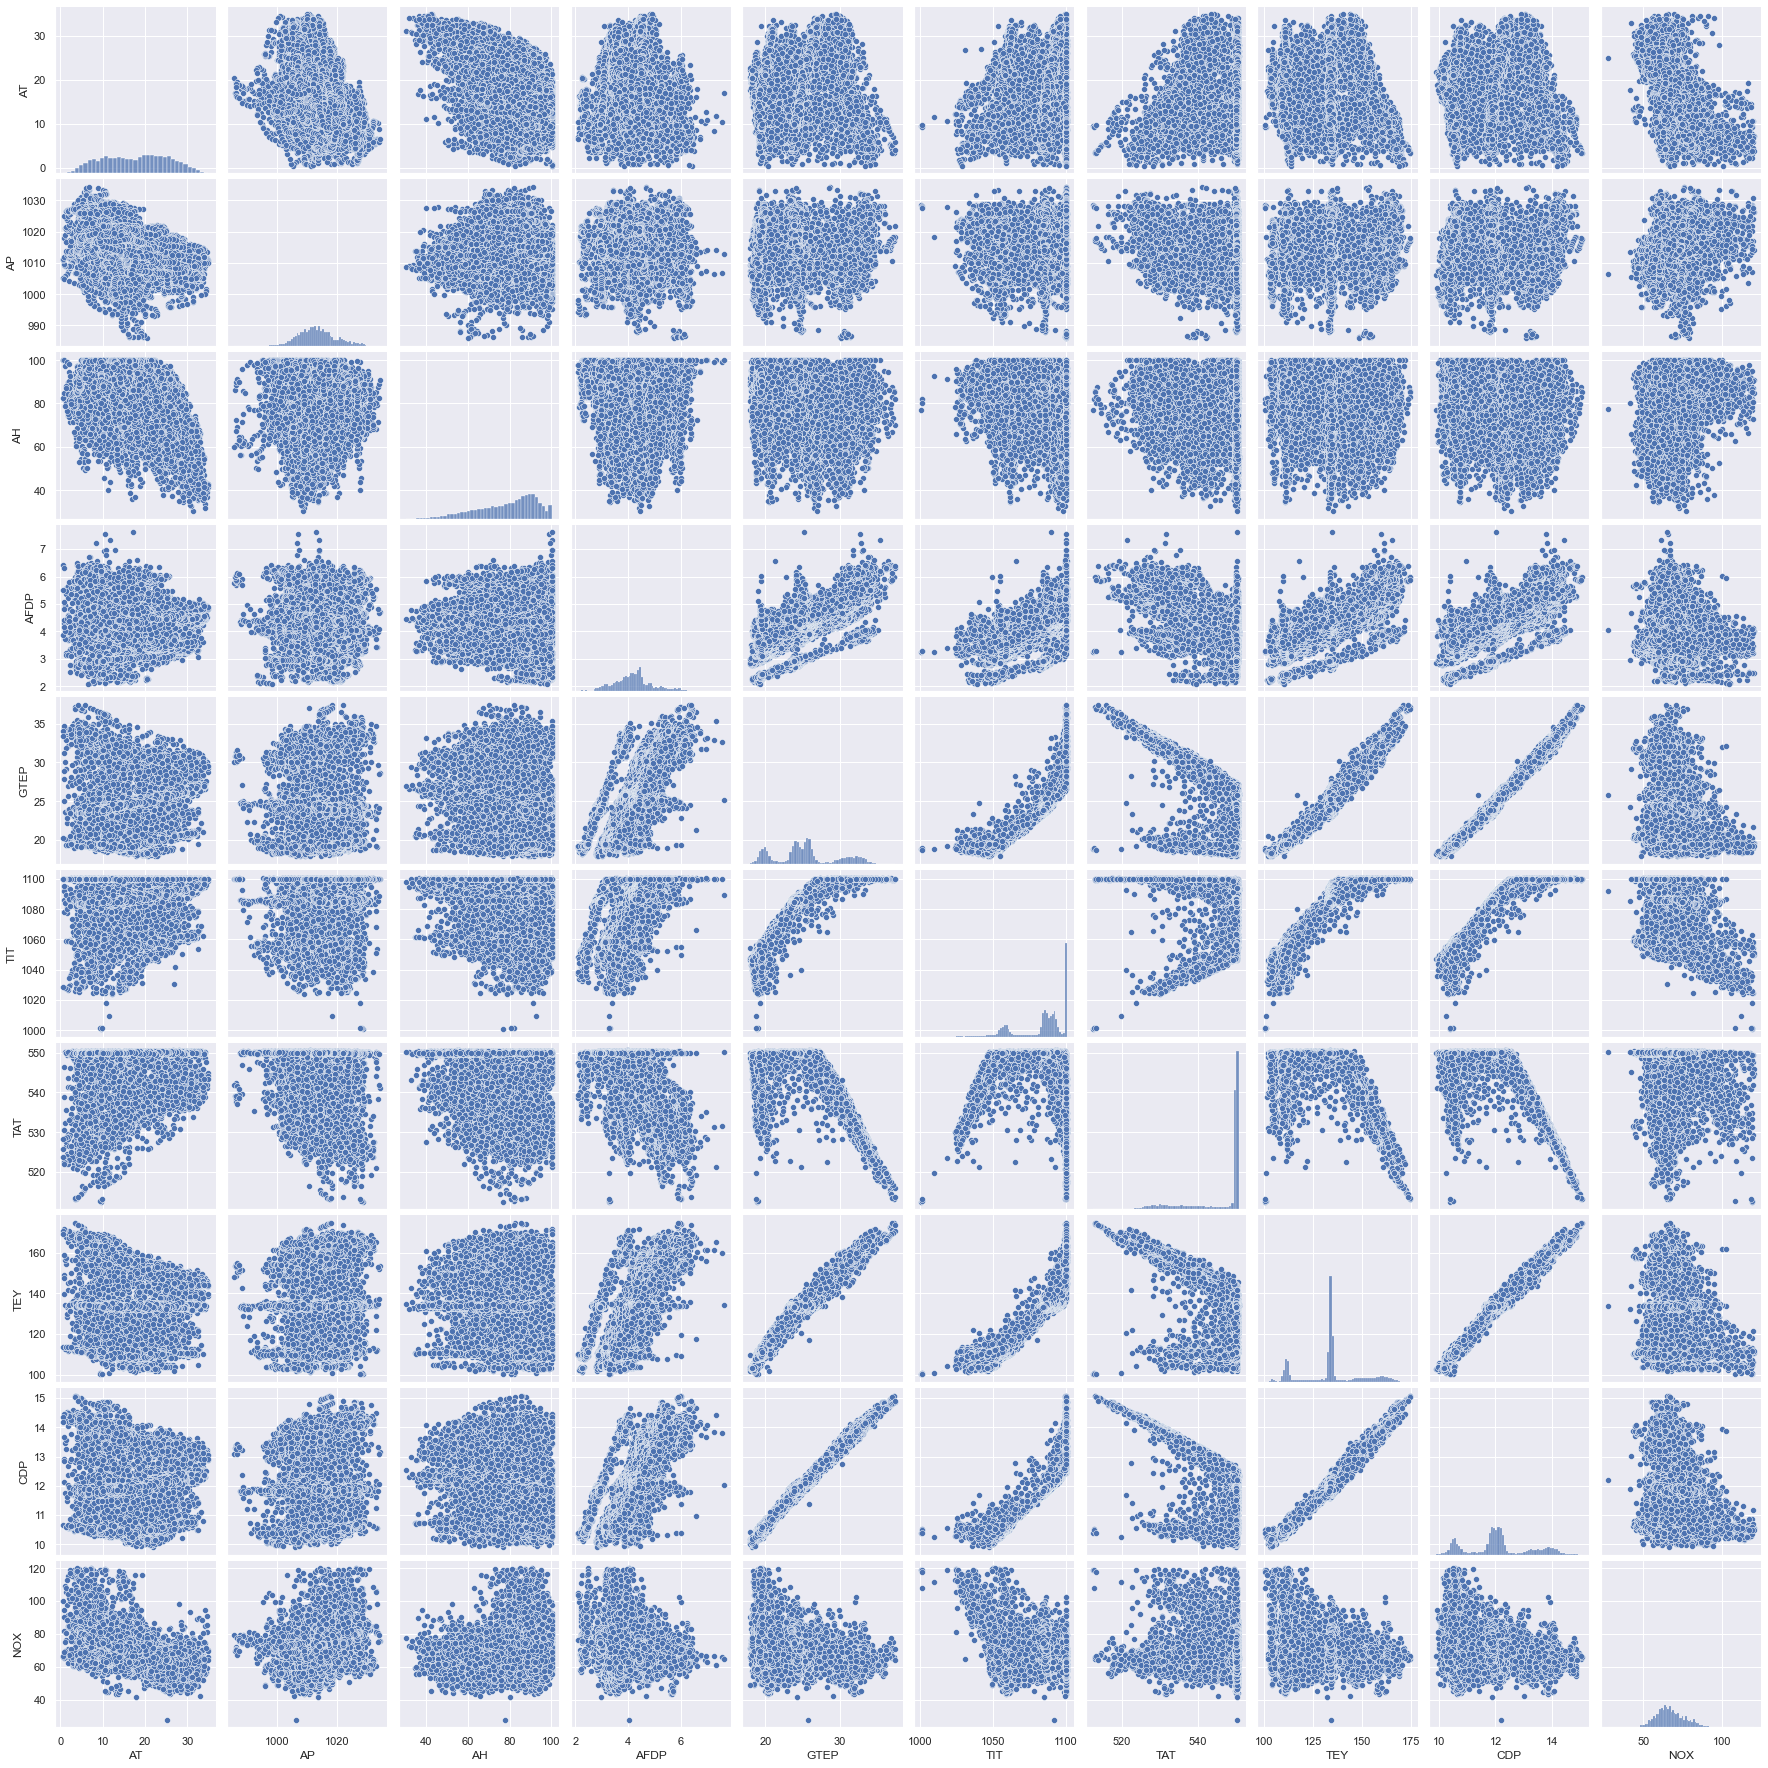

In [16]:
#pair plot
sns.pairplot(df)

The diagonal line along the pair plot are the histograms of the columns.

Some features can add noise while training the model, which results an inaccurate outputs. This issue can be solved using correlation technique.
First, we need to take care of feature correlation. **Feature selection** is a technique where you select features which contribute most to the prediction process. Having highly correlated features can increase overfitting, decreases accuracy and increases training time. <br> Here, we will use the Pearson correlation to compute correlation between columns. The value can be anything in the range between -1 and +1. 

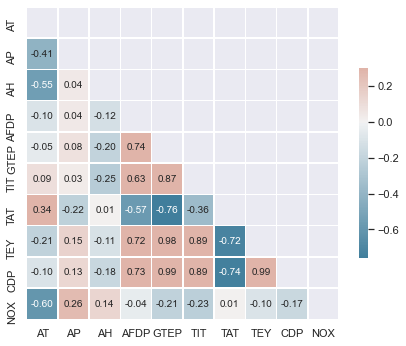

In [17]:
#correlation heatmap
#reference : https://seaborn.pydata.org/examples/many_pairwise_correlations.html

def corrheatmap(dataframe):
    corr = dataframe.corr() # Compute the correlation matrix
    mask = np.triu(np.ones_like(corr, dtype = bool))# Generate a mask for the upper triangle
    f, ax = plt.subplots(figsize=(7,7)) #set up the plt figure
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    return sns.heatmap(round(corr,2), mask = mask, cmap = cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt='.2f')

corrheatmap(df)
plt.show()

From the correlation heatmap, we can see that there are a strong correlations between GTEP and CDP (0.99), TEY and CDP (0.99) and GTEP and TEY (0.98). The reasons to remove highly correlated features are to make learning algorithm faster, low bias and Interpretability of your model.  

I have set correlation threshold value to 0.90. If any two features have a exceed the maximum correlated, then one of those features has to be removed. So, **"CDP" and "TEY"** can be removed. 

In [18]:
#remove TEY and CDP attributes
df = df[['AT','AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'NOX']]
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,NOX
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,81.952
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,82.377
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,83.776
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,82.505
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,82.028


I would like to point out that we didnt remove any highly correlated negative features because this might give a maximum contribution in predicting the output.

## Question: what type of algorithm should we use? classification or regression?
Ofcourse, **the answer is regression.** We are trying to predict a continous output value. Also, this is a supervised machine learning problem.

In supervised machine learning (ML) the goal is to have an accurate model, which based on previously tagged data provides predictions for new data.

#### Now, we will take a look at the process of splitting the data into training and testing dataset.

In [19]:
#independant and dependant values
X = df.iloc[:, :-1].values
y = df.iloc[:,-1].values
print(X.shape, y.shape)

(15039, 7) (15039,)


In [20]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = seed, test_size = 0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12031, 7) (3008, 7) (12031,) (3008,)


## Metrics
There are range of metrics can be used to evaluate the performance of the model. We will consider the MSE metric for our case because the dataset contain outliers. MSE metric is good at handling noise and outliers.

The Mean squared error (MSE) is calculated as the mean of the squared differences between the predicted 
and the actual values

## Section 2: Two Machine Learning models: 


## 1. Random Forest Regression

In [24]:
#empty dictionary to store metrics for different conditions
metrics_dict = {"Model":[], "Hyperparameter":[], "MSE":[],
                "Accuracy (%)":[], "R^2":[]}

In [25]:
#default hyperparameters
rf = RandomForestRegressor(random_state = seed)
rf.fit(X_train, y_train)
print("The parameters are in use: ")
print(rf.get_params())

The parameters are in use: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [26]:
#default predict
rf_predict = rf.predict(X_test)

In [27]:
#Performance  metrics
error = abs(rf_predict - y_test)
mape = np.mean(np.abs((y_test - rf_predict) / np.abs(y_test)))
metrics_dict["Model"].append("Random Forest")
metrics_dict["Hyperparameter"].append("Default")
metrics_dict["MSE"].append(round(metrics.mean_squared_error(y_test, rf_predict),4))
metrics_dict["Accuracy (%)"].append(round(100*(1 - mape), 2))
metrics_dict["R^2"].append(round(metrics.r2_score(y_test, rf_predict),4))
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Model,Hyperparameter,MSE,Accuracy (%),R^2
0,Random Forest,Default,11.9316,96.8,0.8919


We got an accuracy of **96.80%**, which is good. 
The most important question is "How can we improve our results?"
There are several basic ways to improve our prediction model such as: 

    Hyperparameters optimization
    Feature extraction
    Selecting another model
    Adding more data
    Feature selection



Here, we will use hyperparameters optimization technique to improve the accuracy of the model. We will use ***Random Search*** for this task. We are unsure of what set of hyperparameter values are required in order to achieve the best results. We could start with Random Search which is a technique where random combinations of the hyperparameters are used to find the best solution for the given model. To implement this step, we will use ***RandomizedSearchCV*** provided by scikit-learn library.

Most important hyperparameters of Random Forest are:

    n_estimators --> number of trees in random forest
    max_features --> max number of features considered for splitting a node
    max_depth --> max number of levels in each decision tree
    min_samples_split --> min number of data points placed in a node before the node is split
    min_samples_leaf --> min number of data points allowed in a leaf node
    bootstrap = method for sampling data points (with or without replacement)

Piece of advice by Aurelion Geron (2017): 'When you have no idea what value a hyperparameter should have, a simple approach is to try out consecutive powers of 10 (or a smaller number if you want a more fine-grained search)'. We will use this to select the different values for tuning the best hyperparameters.

In [28]:
#RandomizedSearchCV parameter grid

#Number of trees in random forest
n_estimators  = [int(x) for x in range(100,600,100)]
#Number of features to consider
max_features = ["auto", "sqrt"]
#Maximum numebr of levels in tree
max_depth = [int(x) for x in range(10,40,10)]
#Minimum number of samples required to split a node
min_samples_split = [2,5,7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Create the random grid
random_grid = {"n_estimators" : n_estimators,
              "max_features" : max_features,
              "max_depth" : max_depth,
              "min_samples_split" : min_samples_split,
               "min_samples_leaf" : min_samples_leaf ,
              "bootstrap" : bootstrap}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 7], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Using the basic principle of couting, we get(5)x(2)x(3)x(3)x(3)x(2) = **540 combination of settings**. For every interation, the algorithm will randomnly choose a different combination and once all tbhe iterations are done, the final combination is provided as a good hyperparameters. In the below cell, we can see that I have set cross validation to 5 and number of iteration is 100.


In [29]:
#random forest - random search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
                                      cv = 5, verbose = 2, random_state = seed, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [30]:
#best hyperparamters by random search
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [31]:
#predict using hyperparamters by Random search
rf_random = RandomForestRegressor(bootstrap = False, max_depth = 30, max_features = "sqrt",
                                        min_samples_leaf = 1, min_samples_split = 2, n_estimators = 300,
                                         random_state = seed)
rf_random.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt',
                      n_estimators=300, random_state=42)

In [32]:
rf_random_predict = rf_random.predict(X_test)

In [33]:
#Performance  metrics - Random search
error = abs(rf_random_predict - y_test)
mape = np.mean(np.abs((y_test - rf_random_predict) / np.abs(y_test)))
metrics_dict["Model"].append("Random Forest")
metrics_dict["Hyperparameter"].append("Random Search")
metrics_dict["MSE"].append(round(metrics.mean_squared_error(y_test, rf_random_predict),4))
metrics_dict["Accuracy (%)"].append(round(100*(1 - mape), 2))
metrics_dict["R^2"].append(round(metrics.r2_score(y_test, rf_random_predict),4))
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Model,Hyperparameter,MSE,Accuracy (%),R^2
0,Random Forest,Default,11.9316,96.80,0.8919
1,Random Forest,Random Search,10.9093,96.93,0.9012


The accuracy has improved from **96.80 % to 96.93 %**. As we can see that improvement is minimal. We can use ***GridSearch*** to improve the model further. Now, we got a good estimate of suitable hyperparameters which are obtained from ***Random Search*** method. Randomly we will choose some set of values centered aound the current hyperparameters to make further improvement. In this grid search technique, it will try all the given combinations unlike random search which randomly picks combination. 

In [34]:
#GridSearchCV parameter grid

grid = {'max_depth' : [28,29,30,31,32],
 'n_estimators': [int(x) for x in range(250,400, 25)]}
print(grid)

{'max_depth': [28, 29, 30, 31, 32], 'n_estimators': [250, 275, 300, 325, 350, 375]}


Using the basic principle of couting, we get(5)x(6)= **30 combination of settings**.

In [35]:
rf_grid = GridSearchCV(estimator = rf, param_grid = grid, cv = 5, n_jobs = -1, 
                           verbose = 2)
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [28, 29, 30, 31, 32],
                         'n_estimators': [250, 275, 300, 325, 350, 375]},
             verbose=2)

In [36]:
rf_grid.best_params_   

{'max_depth': 30, 'n_estimators': 300}

In [37]:
rf_grid = RandomForestRegressor(bootstrap = False, max_depth = 30, max_features = "sqrt",
                                        min_samples_leaf = 1, min_samples_split = 2, n_estimators = 300,
                                         random_state = seed)
rf_grid.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt',
                      n_estimators=300, random_state=42)

In [38]:
rf_grid_predict = rf_grid.predict(X_test)

In [39]:
#Performance  metrics - Random search
error = abs(rf_grid_predict - y_test)
mape = np.mean(np.abs((y_test - rf_grid_predict) / np.abs(y_test)))
metrics_dict["Model"].append("Random Forest")
metrics_dict["Hyperparameter"].append("GridSearch")
metrics_dict["MSE"].append(round(metrics.mean_squared_error(y_test, rf_grid_predict),4))
metrics_dict["Accuracy (%)"].append(round(100*(1 - mape), 2))
metrics_dict["R^2"].append(round(metrics.r2_score(y_test, rf_grid_predict),4))
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Model,Hyperparameter,MSE,Accuracy (%),R^2
0,Random Forest,Default,11.9316,96.80,0.8919
1,Random Forest,Random Search,10.9093,96.93,0.9012
2,Random Forest,GridSearch,10.9093,96.93,0.9012


### Feature Importance
Lets plot the feature importance graph for this model which assigns a score to features based on how useful they are at predicting a target variable. 

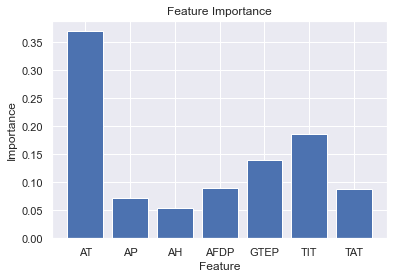

In [40]:
importance = rf_random.feature_importances_
plt.bar([score for score in range(len(importance))], importance, tick_label = df.columns[:-1])
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

From the above plot, the best feature to predict the amount of nitrous oxide emitted is **AT**, followed by **TIT, GTEP, AFDP, TAT, AP and AH.**

## 2. Decision Tree Regression

In [41]:
#default hyperparameters
dt = DecisionTreeRegressor(random_state = seed)
dt.fit(X_train, y_train)
print("The parameters are in use: ")
print(dt.get_params())

The parameters are in use: 
{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


In [42]:
#default predict
dt_predict = dt.predict(X_test)

In [43]:
#Performance  metrics
error = abs(dt_predict - y_test)
mape = np.mean(np.abs((y_test - dt_predict) / np.abs(y_test)))
metrics_dict["Model"].append("Decision Tree")
metrics_dict["Hyperparameter"].append("Default")
metrics_dict["MSE"].append(round(metrics.mean_squared_error(y_test, dt_predict),4))
metrics_dict["Accuracy (%)"].append(round(100*(1 - mape), 2))
metrics_dict["R^2"].append(round(metrics.r2_score(y_test, dt_predict),4))
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Model,Hyperparameter,MSE,Accuracy (%),R^2
0,Random Forest,Default,11.9316,96.80,0.8919
1,Random Forest,Random Search,10.9093,96.93,0.9012
2,Random Forest,GridSearch,10.9093,96.93,0.9012
3,Decision Tree,Default,24.4249,95.42,0.7787


In [44]:
#RandomizedSearchCV parameter grid

#Number of features to consider
criterion = ["mse", "mae"]
#Maximum numebr of levels in tree
max_depth = [int(x) for x in range(2,16,2)]
#Minimum number of samples required to split a node
min_samples_split = [10,20,30,40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [20,40,100]
# Method of selecting samples for training each tree
max_leaf_nodes = [5,15,25,50,75,100]
#Create the random grid
random_grid = {"max_leaf_nodes" : max_leaf_nodes,
              "max_depth" : max_depth,
              "min_samples_split" : min_samples_split,
               "min_samples_leaf" : min_samples_leaf,
               "criterion":criterion
              }

print(random_grid)

{'max_leaf_nodes': [5, 15, 25, 50, 75, 100], 'max_depth': [2, 4, 6, 8, 10, 12, 14], 'min_samples_split': [10, 20, 30, 40], 'min_samples_leaf': [20, 40, 100], 'criterion': ['mse', 'mae']}


In [45]:
#decision tree - random search
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, n_iter = 100,
                                      cv = 5, verbose = 2, random_state = seed, n_jobs = -1)
dt_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 14],
                                        'max_leaf_nodes': [5, 15, 25, 50, 75,
                                                           100],
                                        'min_samples_leaf': [20, 40, 100],
                                        'min_samples_split': [10, 20, 30, 40]},
                   random_state=42, verbose=2)

In [46]:
#best hyperparamters by random search
dt_random.best_params_

{'min_samples_split': 40,
 'min_samples_leaf': 20,
 'max_leaf_nodes': 100,
 'max_depth': 10,
 'criterion': 'mse'}

In [47]:
#predict using hyperparamters by Random search
dt_random = DecisionTreeRegressor(max_depth = 10, criterion = "mse",
                                        min_samples_leaf = 20, min_samples_split = 40, max_leaf_nodes = 100,
                                         random_state = seed)
dt_random.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, max_leaf_nodes=100, min_samples_leaf=20,
                      min_samples_split=40, random_state=42)

In [48]:
dt_random_predict = dt_random.predict(X_test)

In [49]:
#Performance  metrics - Random search
error = abs(dt_random_predict - y_test)
mape = np.mean(np.abs((y_test - dt_random_predict) / np.abs(y_test)))
metrics_dict["Model"].append("Decision Tree")
metrics_dict["Hyperparameter"].append("Random Search")
metrics_dict["MSE"].append(round(metrics.mean_squared_error(y_test, dt_random_predict),4))
metrics_dict["Accuracy (%)"].append(round(100*(1 - mape), 2))
metrics_dict["R^2"].append(round(metrics.r2_score(y_test, dt_random_predict),4))
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Model,Hyperparameter,MSE,Accuracy (%),R^2
0,Random Forest,Default,11.9316,96.80,0.8919
1,Random Forest,Random Search,10.9093,96.93,0.9012
2,Random Forest,GridSearch,10.9093,96.93,0.9012
3,Decision Tree,Default,24.4249,95.42,0.7787
4,Decision Tree,Random Search,21.3248,95.48,0.8068


In [51]:
#GridSearchCV parameter grid
grid = {'max_leaf_nodes' : [80,90,100,110,120],
 'min_samples_split': [30,40,50,60]}
print(grid)

{'max_leaf_nodes': [80, 90, 100, 110, 120], 'min_samples_split': [30, 40, 50, 60]}


In [52]:
dt_grid = GridSearchCV(estimator = dt, param_grid = grid, cv = 5, n_jobs = -1, 
                           verbose = 2)
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_leaf_nodes': [80, 90, 100, 110, 120],
                         'min_samples_split': [30, 40, 50, 60]},
             verbose=2)

In [53]:
dt_grid.best_params_   

{'max_leaf_nodes': 120, 'min_samples_split': 30}

In [54]:
dt_grid = DecisionTreeRegressor(max_depth = 10, criterion = "mse",
                                        min_samples_leaf = 20, min_samples_split = 30, max_leaf_nodes = 120,
                                         random_state = seed)
dt_grid.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, max_leaf_nodes=120, min_samples_leaf=20,
                      min_samples_split=30, random_state=42)

In [55]:
dt_grid_predict = dt_grid.predict(X_test)

In [56]:
#Performance  metrics - GridSearch
error = abs(dt_grid_predict - y_test)
mape = np.mean(np.abs((y_test - dt_grid_predict) / np.abs(y_test)))
metrics_dict["Model"].append("Decision Tree")
metrics_dict["Hyperparameter"].append("GridSearch")
metrics_dict["MSE"].append(round(metrics.mean_squared_error(y_test, dt_grid_predict),4))
metrics_dict["Accuracy (%)"].append(round(100*(1 - mape), 2))
metrics_dict["R^2"].append(round(metrics.r2_score(y_test, dt_grid_predict),4))
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Model,Hyperparameter,MSE,Accuracy (%),R^2
0,Random Forest,Default,11.9316,96.80,0.8919
1,Random Forest,Random Search,10.9093,96.93,0.9012
2,Random Forest,GridSearch,10.9093,96.93,0.9012
3,Decision Tree,Default,24.4249,95.42,0.7787
4,Decision Tree,Random Search,21.3248,95.48,0.8068
5,Decision Tree,GridSearch,20.8021,95.56,0.8116


## Visualising the test and predicted values of two models.

Text(0, 0.5, 'Predicted value')

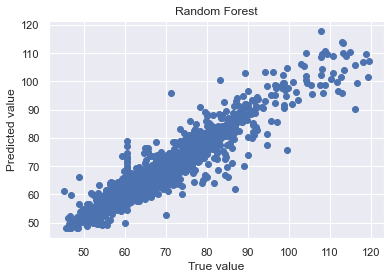

In [60]:
plt.scatter(y_test, rf_grid_predict)
plt.title("Random Forest")
plt.xlabel("True value")
plt.ylabel("Predicted value")

Text(0, 0.5, 'Predicted value')

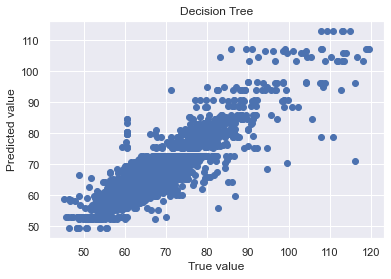

In [61]:
plt.scatter(y_test, dt_grid_predict)
plt.title("Decision Tree")
plt.xlabel("True value")
plt.ylabel("Predicted value")

## Section 3: Baselien model

We will compare our model with a baseline model. There is a class called DummyRegressor provided by scikit learn library. By comparing, we can see how efficient our model performs.

In [82]:
#import dummy regressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
dummy_model = DummyRegressor(strategy = "mean")
dummy_model.fit(X_train, y_train)
dummy_pred = dummy_model.predict(X_test)

mean_squared_error(y_test, dummy_pred, squared=True)

110.41361533768813

In [84]:
#linear regression
dtb = DecisionTreeRegressor()
rfb = RandomForestRegressor()
lmb = LinearRegression()
dtb.fit(X_train, y_train)
rfb.fit(X_train, y_train)
lmb.fit(X_train, y_train)

LinearRegression()

In [85]:
lmb_pred = lmb.predict(X_test)
dtb_pred = dtb.predict(X_test)
rfb_pred = rfb.predict(X_test)

In [87]:
print(f"The MSE of Dummy Regression is {mean_squared_error(y_test, dummy_pred, squared=True)}")
print(f"The MSE of Linear Regression is {mean_squared_error(y_test, lmb_pred, squared=True)}")
print(f"The MSE of Decision Tree Regressor is {mean_squared_error(y_test, dtb_pred, squared=True)}")
print(f"The MSE of Random Forest Regressor is {mean_squared_error(y_test, rfb_pred, squared=True)}")

The MSE of Dummy Regression is 110.41361533768813
The MSE of Linear Regression is 52.94019172969684
The MSE of Decision Tree Regressor is 24.42652098537234
The MSE of Random Forest Regressor is 11.886516535166294


From the above cell, we can see that our models both decision tree and random forest perform better than pother models as both of them have low MSE values. If a model performs worser than baseline, then it should not be considered. 

# 4. Conclusion

To conclude, we did an experiment using two models. The Random forest performs slightly better than decision tree.